# Directional Selectivity in the Drosophila Visual System

In [2]:
"""
A script to convert the drosophila connectome into SpineML 

This build upon the pure data to add in the required infered network components:

# Install libSpineML from source
# https://github.com/AdamRTomkins/libSpineML

"""
from __future__ import division

from libSpineML import smlExperiment as exp
from libSpineML import smlNetwork as net
from libSpineML import smlComponent as com
from libSpineML.smlUtils import  create_spineml_network
from libSpineML.smlUtils import  process_connection_json

from libSpineML.smlUtils import  extract_adjacency_matrix
from libSpineML.smlUtils import  inject_adjacency_matrix
from libSpineML.smlUtils import set_esn_weights
from libSpineML.smlUtils import load_sc_data

from matplotlib import pyplot as plt

import csv
import sys

import cStringIO
import graphviz as gv
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

import copy
import pickle


lpu_dict = pickle.load(( open( "../neuroarch_example/spineml/lpu_dicts.p", "rb" ) ))
connections_json = pickle.load(( open( "../neuroarch_example/spineml/example_connections_json.p", "rb" ) ))

# Build an ESN implementation

We can pass in a custom neuron parameters dictionary to specify the ESN network components


# Create Echo State Inputs

## TODO

4. Add output to the experiment


In [3]:

from utils import *
neuron_params = {'mem_model':
                            {'name':'ESNNode', 'filename':'ESNNode.xml'},
                         'weight_update' :
                            {'name':'ESNWeight', 'filename':'ESNWeight.xml','override':{}},
                         'synapse' :
                            {'name':'ESNConnection', 'filename':'ESNConnection.xml'},
                         'input_model':
                            {'name':'ESNInput', 'filename':'ESNInput.xml'},
                        }
neurons, populations, projections = process_connection_json(connections_json,lpu_dict,neuron_params = neuron_params) 
print "Creating SpineML representation..."

Creating SpineML representation...


In [4]:
trial_length = 100
path_start = 0.3
path_end = 0.7

n_trials = 4

n_outputs = 13

shuffle_trials = True

In [5]:
image = bars_signal(n=100,on_size=3,off_size=10,on_val = 0.5,off_val = 0.1)

centers = {}
    
# Move X directions
centers[0] = generate_centers(trial_length, path_start = path_start,path_end = path_end)
# Move Y directions
centers[1] = generate_centers(trial_length, path_start = path_start,path_end = path_end)
# Move X directions
centers[2] = generate_centers(trial_length, path_start = path_end,path_end = path_start)
# Move Y directions
centers[3] = generate_centers(trial_length, path_start = path_end,path_end = path_start)

images = {}
trials = []


t = 0
for i in np.arange(n_trials):
    trials.append(t)
    t+=1
    if t == n_outputs:t=0

if shuffle_trials:
    from random import shuffle
    shuffle(trials)


trial_data = []
trial_class = []
image_backup = image.copy()

for trial in trials:
    cs = centers[trial]

# Reversing trials
if trial == 1  or trial == 3: 
    image = image_backup.T.copy()
else:
    image = image_backup.copy()

images[trial] = image
data, classes, ps, names = single_trial(image, cs,input_class=trial,hex_radius =0.03)

trial_data.append(data)
trial_class.append(classes)

experiment_classes = np.hstack(trial_class)

experiment_targets= -np.ones((n_outputs,experiment_classes.shape[0]))

for i,c in enumerate(experiment_classes):
    experiment_targets[c,i] = 1

experiment_data = np.ones((trial_data[0].shape[0]*len(trial_data),trial_data[0].shape[1]))

for i,d in enumerate(trial_data):
    experiment_data[i*trial_data[0].shape[0]:(i+1)*trial_data[0].shape[0],:] = d

experiment_data =experiment_data.T

trainlen = experiment_targets.shape[1]/2
future =  experiment_targets.shape[1]/2



In [6]:
names

['home', 'A', 'B', 'C', 'D', 'E', 'F', 'J', 'K', 'L', 'P', 'Q', 'R']

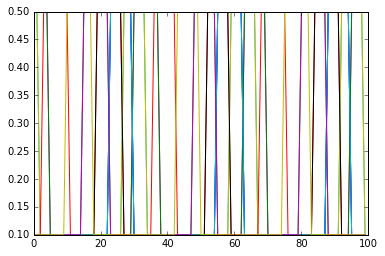

In [7]:
plt.plot(experiment_data.T); plt.show()

## 1. Identify all the input nodes and their connections


In [8]:
cartridges = [k.split('-')[1] for k in neurons.keys() if 'L1' in k]

# Reorder these to fit Input generation 
cartridges.remove(u'home')
cartridges.sort()
cartridges = ['home'] + cartridges



input_neurons = ['L1','L2','L4']

input_nodes = []


for c in cartridges:
    name = str("Input_%s" % c).encode('utf8')
    input_nodes.append(name)
    connections_json['nodes'][name] = {u'class':  u'Input', u'name': name , u'uname': name}

# Add input connections

# for every Input node
for c in cartridges:
    for n in input_neurons:
        pre = str("Input_%s" % c).encode('utf8')
        post = "%s-%s" %(n,c)
        if post in neurons:
            if pre not in connections_json['edges']: connections_json['edges'][pre] ={}
            if post not in connections_json['edges'][pre]: connections_json['edges'][pre][post] ={}
            connections_json['edges'][pre][post] = {u'inferred': 0, u'synapses': 1}


 Adding Input Node: Input_R  
 Adding Input Node: Input_D  
 Adding Input Node: Input_E  
 Adding Input Node: Input_B  
 Adding Input Node: Input_C  
 Adding Input Node: Input_A  
 Adding Input Node: Input_L  
 Adding Input Node: Input_J  
 Adding Input Node: Input_K  
 Adding Input Node: Input_P  
 Adding Input Node: Input_Q  
 Adding Input Node: Input_F  
 Adding Input Node: Input_home  
Creating SpineML representation...
Creating ESN weights...
done


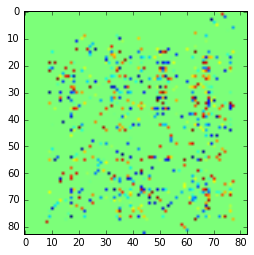

In [9]:
neuron_params = {'mem_model':
                            {'name':'ESNNode', 'filename':'ESNNode.xml'},
                         'weight_update' :
                            {'name':'ESNWeight', 'filename':'ESNWeight.xml','override':{'w':0.2}},
                         'synapse' :
                            {'name':'ESNConnection', 'filename':'ESNConnection.xml'},
                         'input_model':
                            {'name':'ESNInput', 'filename':'ESNInput.xml'}
                }

neurons, populations, projections = process_connection_json(connections_json,lpu_dict,neuron_params = neuron_params) 
print "Creating SpineML representation..."

spectral_radius=1.0
print "Creating ESN weights..."
populations,projections,adjacency_matrix = set_esn_weights(populations,projections, spectral_radius=1.0,weight_parameter='w')


project = create_spineml_network(neurons, populations,
projections,output_filename='ESN_files/test_esn_network.xml',network_name='test_esn_network',project_name= 'drosophila')

print "done"

adjacency_matrix, neuron_index = extract_adjacency_matrix(populations,projections, weight_parameter='w')
plt.imshow(adjacency_matrix)
plt.show()

# Create an Experiment with Input

In [36]:
SpineMLExperiment = exp.SpineMLType()
experiment = exp.ExperimentType()
experiment.name = "ESN"
experiment.description = "NeuroNLP-spineML bridge"
experiment.Simulation = exp.SimulationType(duration=1,preferred_simulator='BRAHMS')

#TODO set Integration MEthod: exp.EulerIntegrationType(dt=1)
steps = 1000
input_signals = {i : np.random.rand(steps) for i in input_nodes}


#for i in input_nodes:
for i,c in enumerate(cartridges):
    # Create a Time Varying Array
    tv = exp.TimeVaryingInputType(
        name="%s_data" % c,
        target="Input_%s" % c,
        target_indices=0,
        port='Input',
        start_time=0,
        duration=steps
    )
    
    #for time,value in enumerate(input_signals[i]):
    for time,value in enumerate(experiment_data[i]):
        tv.add_TimePointValue(exp.TimePointValueType(time=str(time),value=str(value)))
    
    experiment.add_AbstractInput(tv)
    
for p in populations.keys():
    
    out = exp.LogOutputType()
    out.set_name("%s_Output" % p)
    out.set_duration(len(experiment_data[0]))
    #out.set_indices(...)
    out.set_port('activation')
    experiment.add_AbstractOutput(out)
    
SpineMLExperiment.add_Experiment(experiment)

# Create a Project File

In [37]:
from libSpineML import smlBundle

In [38]:
b = smlBundle.Bundle()
b.add_experiment(SpineMLExperiment)

b.add_network(project['network']['component']);

b.add_component(component='ESN_files/ESNInput.xml')
b.add_component(component='ESN_files/ESNNode.xml')
b.add_component(component='ESN_files/ESNWeight.xml')
b.add_component(component='ESN_files/ESNConnection.xml')
b.create_project()

b.export_project('project.proj',project_file='test_project/')


In [39]:
from subprocess import call
call('./run_experiment.sh')


0

In [40]:
num_neurons = 70
(data, count, t) = load_sc_data("./data/unknown-visual_activation_logrep.xml",num_neurons)

In [21]:
x = np.array(data).reshape(num_neurons,int(len(data)/num_neurons))

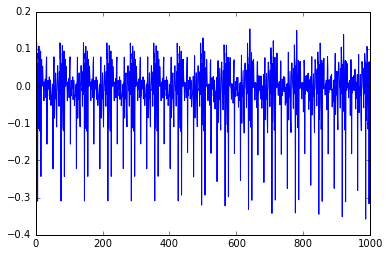

In [42]:
plt.plot(x[1,0:1000])
plt.show()